In [ ]:
# %pip install numpy matplotlib scipy

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Fundamentals of Spike-Train Analysis

Understanding spikes—discrete electrical events that encode information in neurons—is the foundation on which much of computational neuroscience is built. In this first notebook we’ll take raw spike times and, step by gentle step, turn them into meaningful visualisations and summary statistics. Along the way you’ll refresh core NumPy and Matplotlib skills, setting up a toolkit you’ll reuse throughout the course and, hopefully, well beyond it.

## Utility Functions

Running the cell below will create two custom modules: `spikeutils` and `plotutils`, used in the third and fourth sections to simplify the exercises a bit.

In [4]:

########## Spike Generation Utils ############
def gen_spikes(dur=10, rate=1, stim_times = None, max_rate=10, seed=None):
    "Generates some poisson-distributed spikes, moduled by a stimulus period."
    random = np.random.RandomState(seed=seed)
    dt = .01
    t0 = -rate * 10
    times = np.arange(t0, dur, dt)
    if stim_times:
        pdf = stats.uniform(stim_times[0], stim_times[1] - stim_times[0]).pdf(times)
        rates = pdf / pdf.max() * (max_rate - rate) + rate
    else:
        rates = np.full_like(times, rate)
    spikes = np.array([s + t for t, rate in zip(times, rates) if (s := random.exponential(1/rate)) < dt])
    return spikes[spikes > 0]
    


def gen_spikes_multi(n=1, dur=10, rate=1, stim_times = None, max_rate=10, seed=None):
    "Runs the spike generator many times to get a lot of trial runs."
    random = np.random.RandomState(seed=seed)
    trains = []
    for _ in range(n):
        train = gen_spikes(dur=dur, rate=rate, stim_times=stim_times, max_rate=max_rate, seed=random.randint(0, 1000000000))
        trains.append(train)
    return trains


class spikeutils:
    gen_spikes = gen_spikes
    gen_spikes_multi = gen_spikes_multi


########### Plot Utils ###############

def label(title=None, x=None, y=None, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.set(title=title, xlabel=x, ylabel=y)


def remove_spines(ax=None, top=True, bottom=True, left=True, right=True):
    if ax is None:
        ax = plt.gca()
    ax.spines['top'].set_visible(not top)
    ax.spines['bottom'].set_visible(not bottom)
    ax.spines['right'].set_visible(not right)
    ax.spines['left'].set_visible(not left)


def show_grid(x_major=1, x_minor=.4, y_major=1, y_minor=.5, color='white', bgcolor=0.9, ax=None):
    if ax is None:
        ax = plt.gca()

    # Set background color
    background_color = grey(bgcolor) if isinstance(bgcolor, (float, int)) else bgcolor
    ax.set_axisbelow(True)
    ax.set_facecolor(background_color)

    # Set line width and colors (only showing non-zero widths)
    if y_major > 0:
        plt.gca().yaxis.grid(which='major', color=color, linewidth=y_major);
    if y_minor > 0:
        plt.gca().yaxis.grid(which='minor', color=color, linewidth=y_minor);
    if x_major > 0:
        plt.gca().xaxis.grid(which='major', color=color, linewidth=x_major);
    if x_minor > 0:
        plt.gca().xaxis.grid(which='minor', color=color, linewidth=x_minor);



def grey(level=0.5):
    assert 0. <= level <= 1., "grey level sould be between 0 and 1"
    l = int(level * 255)
    return f"#{l:02x}{l:02x}{l:02x}"


def xticks(major=1., minor=0., show=True, ax=None):
    from matplotlib.ticker import MultipleLocator
    if ax is None:
        ax = plt.gca()

    if major:
        ax.xaxis.set_major_locator(MultipleLocator(major)) 
    if not major:
        ax.xaxis.set_visible(False)
    if not show:
        ax.xaxis.set_tick_params('major', length=0)
    if minor:
        ax.xaxis.set_minor_locator(MultipleLocator(minor))
    if not minor or not show:
        ax.xaxis.set_tick_params('minor', length=0)


def yticks(major=1., minor=0., show=True, ax=None):
    from matplotlib.ticker import MultipleLocator
    if ax is None:
        ax = plt.gca()

    if major:
        ax.yaxis.set_major_locator(MultipleLocator(major))
    if not major:
        ax.yaxis.set_visible(False)
    if not show:
        ax.yaxis.set_tick_params('major', length=0)
    if minor:
        ax.yaxis.set_minor_locator(MultipleLocator(minor))
    if not minor or not show:
        ax.yaxis.set_tick_params('minor', length=0)



class plotutils:
    label = label
    remove_spines = remove_spines
    show_grid = show_grid
    xticks = xticks
    yticks = yticks


### Numpy Review with Spike Trains: Indexing and Slicing

Spike times are, at heart, just numerical arrays—perfect territory for a quick NumPy warm-up. Here we’ll revisit slicing, boolean masks, and vectorised arithmetic, using spike-train examples so that every line of code maps onto something a neuron actually did. 

| Code | Description |
| :-- | :-- |
| **`spikes = np.array([1, 2, 4])`** | Construct a numpy array from a list of three spike events |
| **`spikes2 = spikes + 3`** | Add 3 seconds to all spike times. |
| **`spikes2 = spikes * 10`** | Multiply 10 seconds to all spike times. |
| **`isi = np.diff(spikes)`** | Calculate the inter-interval spike times by subtracting neighboring values |
| **`spikes = np.cumsum(isi)`** | Calculate spike times by adding neighboring ISIs |
| **`rates = 1 / isi`** | Calculate the "instantaneous" firing rates (i.e. the inverse of ISI) |



**Exercises**

**Example**: Convert the spike train array below from seconds to milliseconds by multiplying.

In [6]:
spikes = np.array([.2, .5, .9])
spikes

array([0.2, 0.5, 0.9])

In [7]:
spikes * 1000

array([200., 500., 900.])

The spike times below show the times that a spike happened releative to the start of a trial.  Let's change them to be post-stimulus time by subtracting.

In [8]:
spikes = np.array([.2, .5, .9, 1.3, 1.8, 2.9])
stimtime = 0.9

In [9]:
spikes - stimtime

array([-0.7, -0.4,  0. ,  0.4,  0.9,  2. ])

The spike times below are not in order--this makes it hard to tell what spikes happened first, and even calculate the ISI ("Inter-Spike Interval") between consecutive spikes.  Using `np.sort()`, let's sort the spike times in ascending order.

In [10]:
spikes =  np.array([5.5, 1.1, 2.2, 6.6, 4.4, 3.3])
spikes

array([5.5, 1.1, 2.2, 6.6, 4.4, 3.3])

In [12]:
np.sort(spikes)[::-1]

array([6.6, 5.5, 4.4, 3.3, 2.2, 1.1])

Make a spike train containing spike events at 0.2, 0.5, and 0.9 seconds.  Using `np.diff()`: what are the spikes' ISIs? (Note: Add `prepend=np.nan` if you'd like a placeholder for the first spike.)

In [18]:
spikes = np.array([.2, .5, .9])
np.diff(spikes, prepend=np.nan)

array([nan, 0.3, 0.4])

Make a spike train containing spike events at 0.7, 0.8, 1.0, and 1.3 seconds. Using `np.diff()`: what are the spikes' ISIs? (Note: Add `prepend=np.nan` if you'd like a placeholder for the first spike.)

The spike times below should have an average firing rate of 4 Hz (spikes per second). Let's check this:  Using the provided algorithm, calculate  the average spike rate of the spikes below:
  1. Convert the spike times to ISIs (`np.diff()`).
  2. Calculate the average ISI (`np.mean()`).
  3. Calculate the inverse of the average ISI (`1 / x`)

In [19]:
spikes = np.array([0.5, 0.8, 1.3, 1.4, 1.5])

In [24]:
1 / np.mean(np.diff(spikes))

np.float64(4.0)

Create a spike train from the array of ISIs belowc using `np.cumsum()`.  Using `np.append(0, arr)` to add the missing t=0 spike from the sequence, then adding the time of the first spike to all the spike times will recover the original spike times.

In [ ]:
isis = np.array([.1, .2, .2, .3, .1])
first_spiketime = 0.5

In [28]:
np.cumsum(isis) + first_spiketime

array([0.6, 0.8, 1. , 1.3, 1.4])

## Indexing and Slicing Review with Raster Plots of Spike Trains

Seeing data is believing. Once you can pull out subsets of spikes with NumPy, the natural next step is to visualise them with a raster plot. This section ties indexing tricks to immediate graphical pay-offs, reinforcing the idea that a well-chosen slice not only speeds computation but also sharpens the story your data tell.

| Code | Description |
| :-- | :-- |
| **`x[0], x[-1]`**  | get the first and last spike time in the array |
| **`x[2:4]`** | Get the third-to-fifth spike times in the array |
| **`x[x > 3]`** | Get all spike times that occured after t=3 |
| **`x[(1 <= x) & (x < 4)]`** | Get all spike times between 1 and 4 secs. |
| **`plt.eventplot(spikes)`** | Make a rasterplot of spike events |


**Exercises**: Analyze the randomly-generated spike train below.

In [30]:
np.random.seed(3)
isis = np.random.exponential(1, size=40)
isis[20:] /= 3
spikes = np.append(0.00, isis.cumsum() ).round(3)
spikes

array([ 0.   ,  0.8  ,  2.032,  2.376,  3.091,  5.325,  7.591,  7.725,
        7.958,  8.01 ,  8.592,  8.622,  9.232, 10.28 , 10.606, 11.734,
       12.628, 12.652, 13.47 , 13.77 , 14.307, 14.418, 14.812, 15.005,
       15.062, 15.324, 15.83 , 15.951, 16.035, 16.199, 17.117, 18.36 ,
       18.732, 19.509, 20.132, 20.291, 20.323, 20.676, 20.948, 21.098,
       21.183])

**Example**: What time in the trial was the first spike?

In [31]:
spikes[0]

np.float64(0.0)

What time in the trial was the 3rd spike?

In [35]:
spikes[2].item()

2.032

What time in the trial was the last spike?

In [36]:
spikes[-1]

np.float64(21.183)

How many spikes were there before t=15?

In [37]:
spikes[spikes < 15]

array([ 0.   ,  0.8  ,  2.032,  2.376,  3.091,  5.325,  7.591,  7.725,
        7.958,  8.01 ,  8.592,  8.622,  9.232, 10.28 , 10.606, 11.734,
       12.628, 12.652, 13.47 , 13.77 , 14.307, 14.418, 14.812])

Make a raster plot of only the first 10 seconds' worth of spikes.  (The `plt.eventplot()` function can be used to make a raster plot of spike times.)

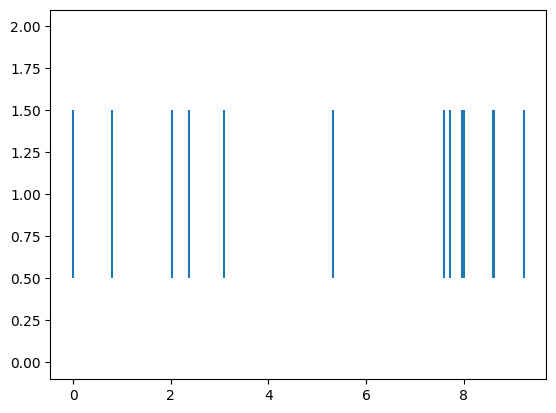

In [40]:
plt.eventplot(spikes[spikes < 10]);

Make a raster plot of only the times between t=5 and t=20.

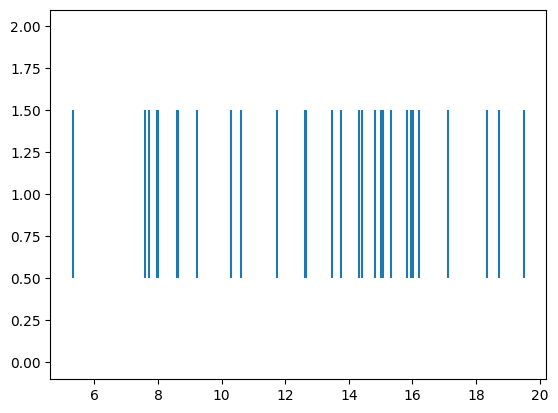

In [42]:
plt.eventplot(spikes[(5 < spikes) & (spikes < 20)]);

Below are the Inter-stimulus intervals (ISIs). What is the mean ISI for the first 20 spikes? (note: because there's a NaN in the data, using `np.nanmean()` instead of `np.mean()` will help.)

In [ ]:
isis = np.diff(spikes, prepend=np.nan).round(3)
isis

What is the mean ISI for the last 20 spikes?

(Challenge Question): What is the mean ISI for the spikes between t=0 and t=10?

(Challenge Question): Were there more spikes in the first 5 seconds or in the last 5 seconds of the trial?

### Plotting Spike Event Data: Reviewing Plotting with Matplotlib

Matplotlib remains the workhorse for scientific figures in Python, and spike trains pose a few special challenges—densely packed events, multiple trials, and millisecond-scale timing. Here we’ll review core plotting commands through the lens of neural data: event plots, histogram bins, axis scaling, and annotation. The goal is to give you a reliable recipe for turning arrays of spike times into clear, publication-ready figures without getting lost in Matplotlib’s vast option space.

.
| Code | Description |
| :-- | :-- |
| **`plt.eventplot(events)`** | Make a raster plot. |
| **`plt.step(x, y, where='post')`** | Make a step plot, showing a line with sudden changes at measurement points. |
| **`plt.pcolormesh(x, y, img)`** | Make a heatmap. |
| **`plt.fill_between(x, y1, y2)`** | Make a shaded region over x, good for representing an error region in a continuous plot. |
| **`plt.xlabel(), plt.ylabel()`** | Make a text label for the x or y axes. |
| **`plt.legend()`** | Show a legend. |
| **`plt.colorbar()`** | Show a colorbar. |

**Exercise**: Plot the spike times generated below in as a rasterplot using `plt.eventplot()`, and label the x-axis as `"Time (sec)"` with `plt.xlabel()`. Can you see a difference in spike firing rates between t=40 and t=55?  (Note: the events might pop better if `linewidths` is set to `0.5` and `colors` is set to `"black"`)


In [43]:
spikes = spikeutils.gen_spikes(dur=120, rate=1, stim_times=[70, 90], max_rate=2.3, seed=3)
print(f'{spikes.size} spike events generated from t=0 to t=90.')


126 spike events generated from t=0 to t=90.


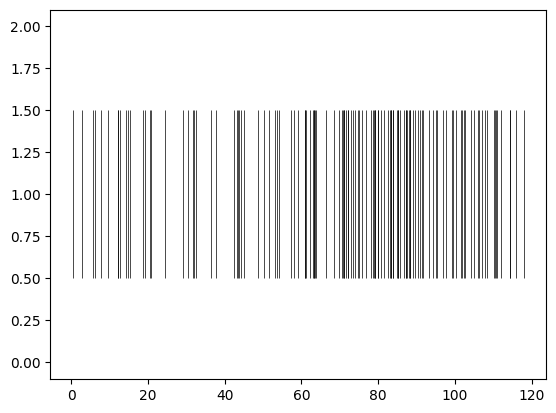

In [47]:
plt.eventplot(spikes, linewidths=0.5, color='black');

**Exercise**: Using `plt.step()`, make a step plot showing how the the spike times vs averge spike rates (calculated below in the `times` and `rates` variables), looking at how the average number of spikes in a time bin changes.  Does this plot show a noticable change in mean firing rate between t=50 and t=70? Be sure to label the x-axis as `"Time (sec)"` and the y-axis as `"Mean Firing Rate (Hz)"`.
  - Tip: the trainsition point might be clearer if `where` is set to `"post"`.
  - How does using `plt.step()` differ from using `plt.plot()`?

In [48]:
spikes = spikeutils.gen_spikes(dur=120, rate=1, stim_times=[70, 90], max_rate=2.3, seed=3)
print(f'{spikes.size} spike events generated from t=0 to t=90.')
binwidth = 5
counts, time_bins = np.histogram(spikes, bins=np.arange(0, 120.1, binwidth))
times = time_bins[:-1]
rates = counts / binwidth
times, rates

126 spike events generated from t=0 to t=90.


(array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
        110., 115.]),
 array([0.4, 0.8, 1. , 0.6, 0.6, 0.2, 0.8, 0.4, 1. , 0.4, 1. , 0.6, 1.8,
        0.6, 2.4, 1.8, 1.8, 2.4, 1.2, 1.2, 1.4, 1. , 1.4, 0.4]))

In [ ]:
plt.step

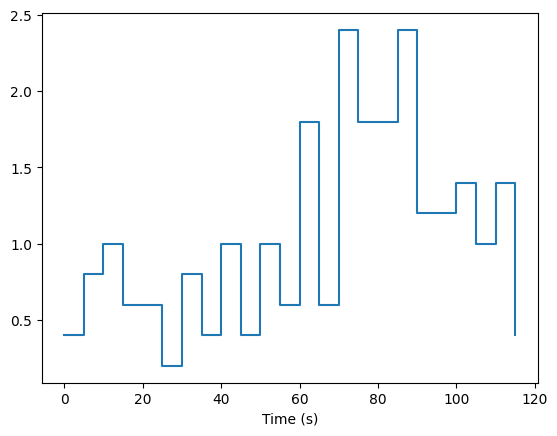

In [53]:
plt.step(times, rates, where='post');
plt.xlabel('Time (s)');

**Exercise**: Let's collect many trials' worth of data from this cell.  Using the spike trains `trains` variable, which contains a list of spike time arrays, make a raster plot showing the spike times.
  - try to make each spike event appear as distinctly as you can in the plot, by manipulating the `linewidths`, `linelengths`, and `colors` parameters of `plt.eventplot()`.
  - Be sure to label the x and y axes, plus add the title `"Raster Plot"`.  
    - A utility function has been provided to make this easier: `plotutils.label(x="X Label", y="Y Label", title="Title")`

In [54]:
trains = spikeutils.gen_spikes_multi(n=50, dur=120, rate=1, stim_times=[70, 90], max_rate=2.3, seed=3)
print(f"{len(trains)} trials generated, with a total of {sum([s.size for s in trains])} Spikes.")
len(trains)

50 trials generated, with a total of 7316 Spikes.


50

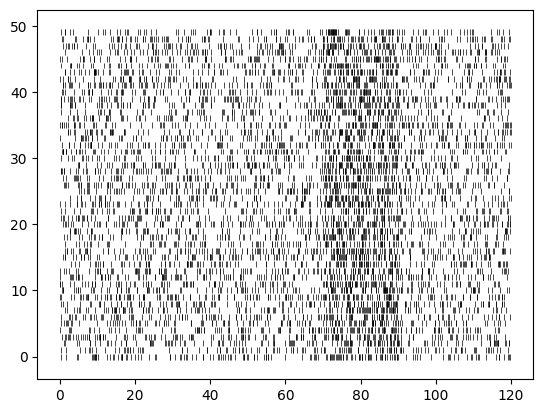

In [57]:
plt.eventplot(trains, linewidths=0.5, colors='black', linelengths=0.9);

**Exercise**: Let's use `plt.pcolormesh(x, y, matrix)` to make a heatmap showing the mean firing rate over time for each of the trials (calculated below, in the variables `trials`, `time_bins`, and `counts`).
  - Adding a colorbar with `plt.colorbar(label='Firing Rate (Hz)') will make it easier to interpret the colors in the heatmap.
  - Be sure to label the x axis, y axis, and title as well.

In [58]:
t = np.arange(0, 121, (bin_size := 2))
time_bins = t[:-1]
counts = np.array([np.histogram(s, bins=t)[0] / bin_size for s in trains])
trials = np.arange(1, len(trains) + 1)


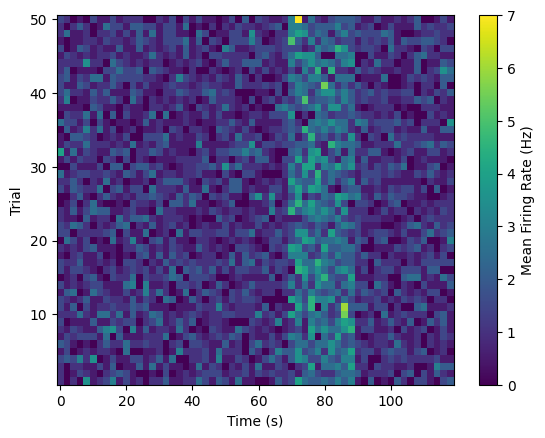

In [63]:
plt.pcolormesh(time_bins, trials, counts);
plt.colorbar(label='Mean Firing Rate (Hz)');
plt.xlabel('Time (s)')
plt.ylabel('Trial');

**Exercise**: Let's plot the mean firing rate across trials, calculated below in `mean_counts`, using `plt.plot()`.  
  - How precisely have we estimated the expected firing rate?  Make an error band using `plt.fill_between()`, using `errorbars.low` and `errorbars.high` to define the 95% confidence interval for the error bars.
  - Be sure to label the x-axis, y-axis, and title.
  - Make it easy to interpret the line and shaded region by adding `label=` parameters for each of the plotting functions, and calling `plt.legend()` to make a legend.
    - Note: if you'd like to ensure the legend is out of the way of the data, add the parameter `bbox_to_anchor=(1.0, 1.0)` to the `plt.legend()` function call.


In [64]:
time_bins = t[:-1]
mean_counts = np.mean(counts, axis=0)
errorbars = stats.bootstrap((counts,), np.mean).confidence_interval

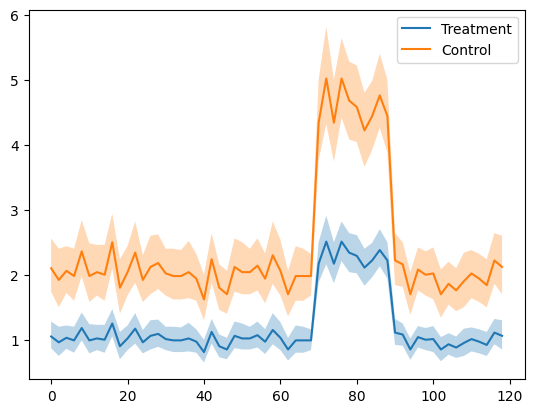

In [72]:
plt.plot(time_bins, mean_counts, label='Treatment');
plt.fill_between(time_bins, errorbars.low, errorbars.high, alpha=.3);

plt.plot(time_bins, mean_counts * 2, label='Control');
plt.fill_between(time_bins, errorbars.low * 2, errorbars.high * 2, alpha=.3);

plt.legend()

## Customizing Plots to Make them Really Clean 

Great figures distil complex data into straightforward visual messages. In this final section we’ll polish our initial plots—adjusting tick marks, colours, and labels—to make them easy for colleagues (and reviewers!) to interpret at a glance. You’ll see how small aesthetic tweaks, applied systematically, raise a figure from “good enough” to “communicates instantly,” a skill that pays dividends in every presentation and paper you create.

**Exercise**: Below is the raster plot from the last section.  It's nice, but it contains extra elements that don't have meaning in the plot, and it is missing some information to help interpret the data.  Let's improve it!  Make the following improvements to the plot:
  1. Since the y-axis doesn't have meaning, here it can confuse readers.  We can hide it with `utils.remove_spines()
  2. Hide the y-axis values with `plotutils.yticks(None)`
  3. Now there is a lot of unused white space in the plot.  Let's make the figure fit the data better by setting the figure dimensions manually: `plt.figure(figsize=(8, 1))`
  4. It's a little tough to precisely estimate the spike times.  Let's set the x-tick resolution with `plotutils.xticks(10, 2.5)`
  5. The box around the plot (called the "spines") aren't really adding any information here.  Let's remove them with `plotutils.remove_spines()`.
  5. To make the stimulus period clear in the plot (t=50 - t=70), make a shaded region using `plt.axvspan()`, setting `alpha=.1` to make it transparant and `zorder=1` to make sure it appears behind the rasters.


In [ ]:
plt.eventplot(spikes, linewidths=0.5, colors='black');
plotutils.label(x='Time (sec)');


**Exercise**: Below is the step plot made in the last section.  This is also good, but challenging aspect for readers is to estimate the firing rate at each point in time--there isn't much visual information here to help with that.  Let's work on adding a clean grid to make those estimates straightforward:
  1. Make a grid with `plotutils.show_grid()`.  The default is a light grey grid with white lines, so it doesn't distract from the data, but the colors and line widths can be changed.
  2. Help readers estimate the firing rate with 0.25 Hz by setting the major tick frequency to 0.5 and the minor frquency to 0.25: `plotutils.yticks(.5, .25)`.
  3. Help readers see the change at t=70 by setting the x-tick frequency to 10: `plotutils.xticks(10)`.
  4. Once again, the spines are in the way of reading from the numbers to the white lines.  Remove the spines with `plotutils.remove_spines()`.
  5. The black tick marks on the x- and y- axis are now redundant.  Hiden them by setting `show=False` on both the `xticks()` and `yticks()` functions.
  6. To make the stimulus period clear in the plot (t=50 - t=70), make a shaded region using `plt.axvspan()`, setting `alpha=.1` to make it transparant and `zorder=1` to make sure it appears behind the plot and above the grid.


In [ ]:
plt.step(times, rates, where='post');
plotutils.label(title='Binned Spike Rates over Time', x='Time (sec)', y='Mean Firing Rate (Hz)')


**Exercise**: All three of the plots for the multi-trial analysis are below.  They are all important: they show the data collected, the first-level aggregation, and the inference model, respectively.  What's needed now is to put them together into a figure to tell a clear story.  Let's turn these three figures into subplots to make it more clear that they belong together!
  1. Change each of teh `plt.figure()` calls into a `plt.subplot()` call, describing the plot as having 1 row and 3 columns by calling them this way: `plt.subplot(1, 3, 1)`, `plt.subplot(1, 3, 2)`, and `plt.subplto(1, 3, 3)`.
  2. Make room for the plots by first creating the figure with pre-set dimensions: `plt.figure(figsize=(16, 4))`.
  3. Add a title for the whole figure, a "Super Title", with `plt.suptitle("Firing Rates for Cell 3 Across All Trials")`
  4. Let Matplotlib clean up the whitespace layout a bit by calling `plt.tight_layout()` right at the end.

In [ ]:
plt.figure()
plt.eventplot(trains, linewidths=.5, colors='black', lineoffsets=1.5)
plotutils.label('Raster Plot', x='Time (s)', y='Cell #')

plt.figure()
plt.pcolormesh(counts)
plotutils.label('Binned Firing Rates', x='Time (s)', y='Cell #')

plt.figure()
plt.plot(time_bins, mean_counts, label='Mean Firing Rate')
plt.fill_between(x=time_bins, y1=errorbars.low, y2=errorbars.high, alpha=.3, label='95% CI', zorder=1)
plt.legend(bbox_to_anchor=(1.0, 1.0)) 
plt.xlim(0)
plotutils.remove_spines()
plotutils.xticks(10, show=False)
plotutils.yticks(.5, show=False)
plotutils.label('Mean Binned Firing Rates', x='Time (s)', y='Mean Firing Rate')
plotutils.show_grid()
